# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures.spikes import compute_firing_rate
from spiketools.spatial.occupancy import compute_occupancy
from spiketools.plts.data import plot_bar, plot_hist, plot_lines
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import add_hlines, add_vlines
from spiketools.utils.timestamps import convert_sec_to_min
from spiketools.utils.extract import get_range, get_value_by_time, get_values_by_time_range
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.utils.data import compute_range
from spiketools.utils.base import count_elements

In [3]:
import sys
sys.path.append('../code')
from utils import select_navigation
from plts import plot_task_structure

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
#data_folder = '/data12/jacobs_lab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 0,
}

In [7]:
# Define bins to use
#bins = [7, 21]
bins = [6, 10]

In [8]:
# Define occupancy related settings
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

## Load NWB Data

In [9]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [10]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x140283839879440
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    head_direction <class 'pynwb.behavior.CompassDirection'>,
    position <class 'pynwb.behavior.Position'>,
    recall <class 'pynwb.behavior.Position'>,
    stimuli <class 'pynwb.behavior.Position'>
  }
  data_collection: West Virginia
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    bundle1 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Task: TH1 build-2.102 (English)
  experimenter: ['Donoghue, Thomas' 'Cao, Runnan' 'Han, Zhixian' 'Holman, Cameron'
 'Brandmeir, Nicholas J' 'Wang, Shuo' 'Jacobs, Joshua']
  file_create_date: [datetime.datetime(2022, 8, 31, 16, 26, 10, 384766, tzinfo=tzoffset(None, -14400))]
  identifier: THF_wv001_session_0
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeInterv

## Task Structure

In the following, shadings are:
- green is encoding (navigation)
- yellow is the distractor task
- purple is recall (using the selector)

In [11]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 14


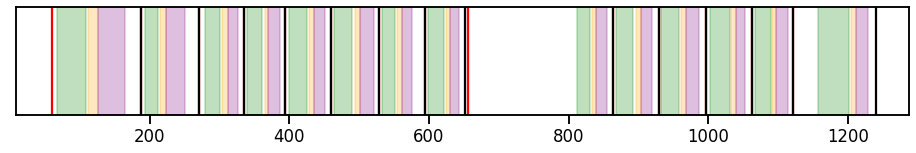

In [12]:
# Plot the task structure for the whole recording
plot_task_structure(nwbfile.trials)

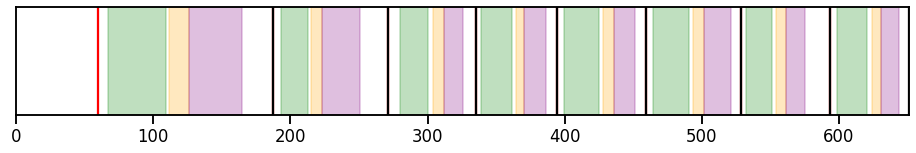

In [13]:
# Plot the task structure for a single block
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[7]])

## Position Data

In [14]:
# Extract the position data
pos = nwbfile.acquisition['position']['player_position']
pos

player_position pynwb.behavior.SpatialSeries at 0x140283840628240
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (17326, 2), type "<f8">
  description: Position of the player.
  interval: 1
  offset: 0.0
  reference_frame: corner
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (17326,), type "<f8">
  timestamps_unit: seconds
  unit: virtual units

#### Plot all position data

This includes self-navigation, and transport.

In [15]:
# Extract position timestamps and values
ptimes = pos.timestamps[:]
positions = pos.data[:].T

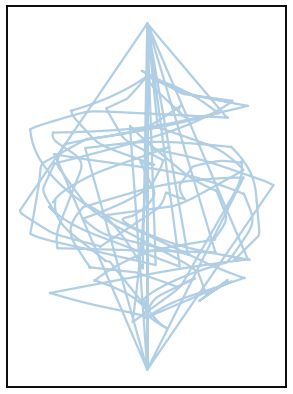

In [16]:
# Plot the map across all position traces
plot_positions(positions, figsize=(5, 7))

#### Select position only from navigation

In [17]:
# Epoch position data to self-navigation
ptimes_trials, positions_trials = select_navigation(\
            nwbfile.acquisition['position']['player_position'], 
            nwbfile.trials.navigation_start[:], nwbfile.trials.navigation_stop[:])

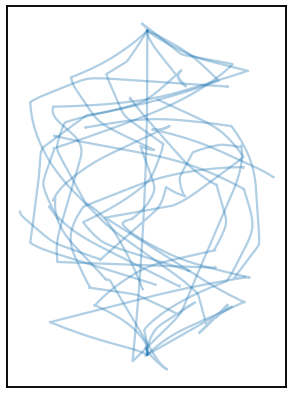

In [18]:
# Plot navigation-trial level position data
plot_positions(positions_trials, figsize=(5, 7))

In [19]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

In [20]:
# Check position ranges & compare to boundaries
print('X data range: \t{:6.2f} - {:6.2f}'.format(*compute_range(positions[0, :])))
print('Z data range: \t{:6.2f} - {:6.2f}'.format(*compute_range(positions[1, :])))
print()
print('X boundary: \t{:6.2f} - {:6.2f}'.format(*x_boundary))
print('Z boundary: \t{:6.2f} - {:6.2f}'.format(*z_boundary))

X data range: 	366.46 - 402.55
Z data range: 	285.00 - 433.00

X boundary: 	349.85 - 419.85
Z boundary: 	293.00 - 424.34


In [21]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]

#### Check speed

In [22]:
# Get speed
speed = nwbfile.processing['position_measures']['speed'].data[:]

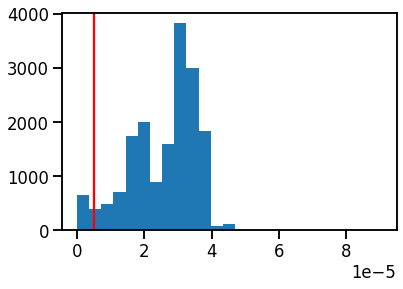

In [23]:
# Plot the histogram of speed values, and compare to threshold
plot_hist(speed, bins=25)
add_vlines(speed_thresh, color='red')

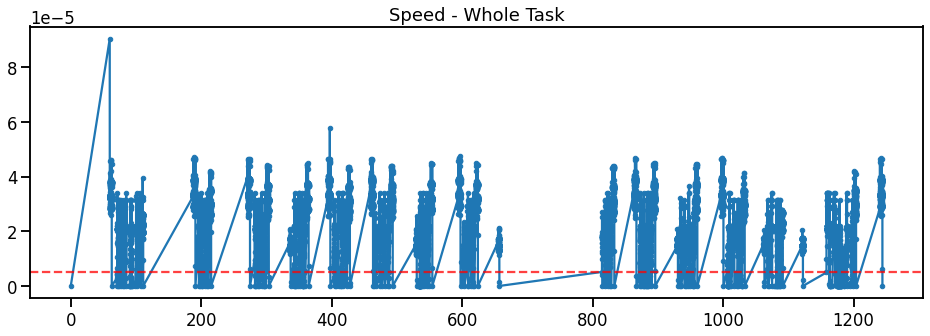

In [24]:
# Plot the speed across the whole task
plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task', figsize=(16, 5))
add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

In [25]:
# Extract speed across a single navigation period (trial)
t_ind = 5
t_times, t_speed = get_values_by_time_range(
    ptimes, speed, nwbfile.trials.navigation_start[t_ind], nwbfile.trials.navigation_stop[t_ind])

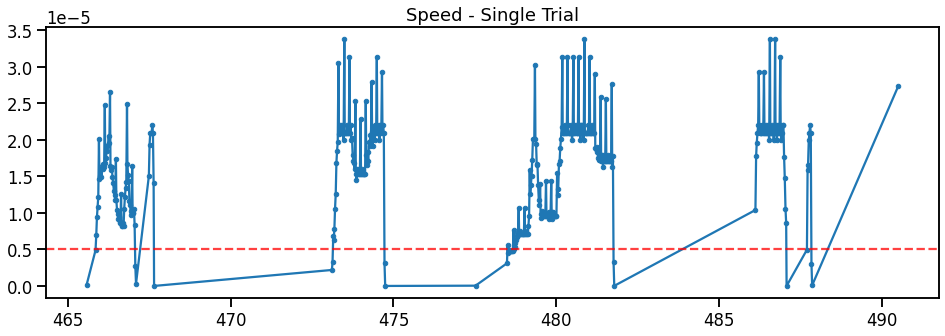

In [26]:
# Plot the speed across a single navigation session (one trial)
plot_lines(t_times, t_speed, marker='.', title='Speed - Single Trial', figsize=(16, 5))
add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

#### Check position samples from across navigation

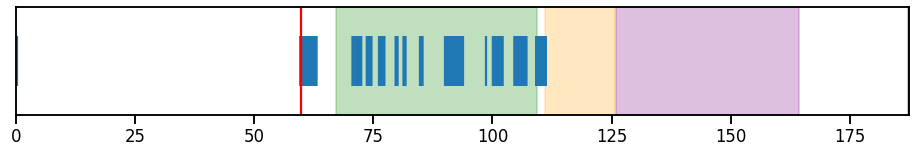

In [27]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials,
                    data_points=get_range(ptimes, 0, nwbfile.trials.stop_time[0]),
                    xlim=[0, nwbfile.trials.stop_time[0]])

## Occupancy

In [28]:
# Collect settings for occupancy
occ_kwargs = {'time_threshold' : time_thresh, 'minimum' : min_occ,
              'normalize' : False, 'set_nan' : True}

In [29]:
# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, **occ_kwargs)

/Users/tom/opt/anaconda3/envs/spike/lib/python3.8/site-packages/spiketools/utils/checks.py:111: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


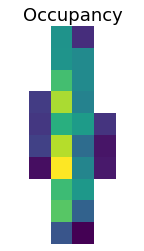

In [30]:
# Plot the occupancy
plot_heatmap(occ, title="Occupancy", figsize=(5, 4))

## Stimuli

In [31]:
# Collect chest positions
chest_pos = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T

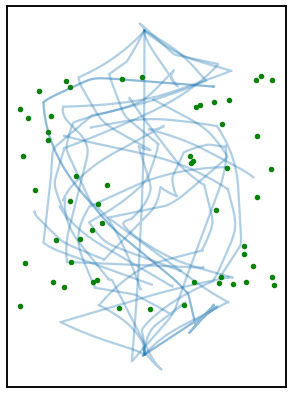

In [32]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions_trials, alpha=0.5, figsize=(5, 7),
               landmarks={'positions' : chest_pos, 'color' : 'green'})

In [33]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.trials.chest_trials[:]
chest_trials

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13])

### Trial-by-Trial

In the following representation:
- purple dots are the trial start location
- orange dots are the trial end location (where they do recall from)
- green dots are the chest locations

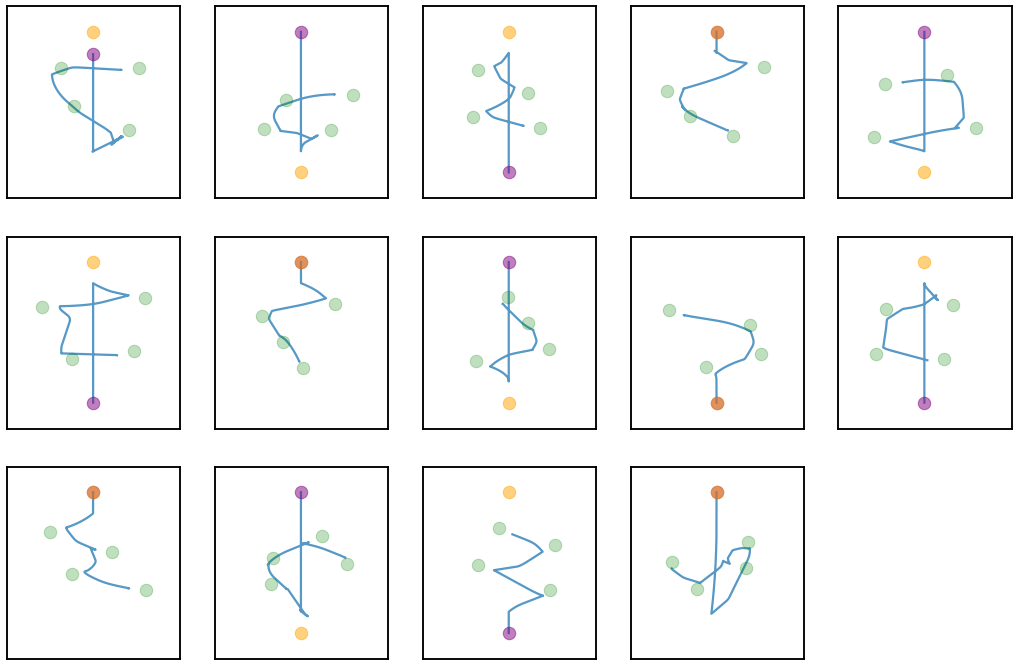

In [34]:
# Plot the trajectories for each trial
for t_ind, ax in zip(range(n_trials), make_axes(n_trials)):

    # Extract the position data for the current trial, from trial start to last chest opening time
    t_time, t_pos = get_values_by_time_range(ptimes, positions,
                                             nwbfile.trials['start_time'][t_ind],
                                             nwbfile.trials['chest_opening_time'][t_ind][-1])
    
    # Plot the position traces
    plot_positions(t_pos, alpha=0.75, 
                   landmarks=[{'positions' : t_pos[:, 0],
                               'color' : 'purple', 'ms' : 25, 'alpha' : 0.5},
                              {'positions' : get_value_by_time(ptimes, positions,
                                                               nwbfile.trials['stop_time'][t_ind]),
                               'color' : 'orange', 'ms' : 25, 'alpha' : 0.5},
                              {'positions' : chest_pos[:, chest_trials == t_ind],
                               'color' : 'green', 'ms' : 25, 'alpha' : 0.25}],
                   xlim=x_boundary, ylim=[z_boundary[0]-35, z_boundary[1]+35],
                   ax=ax)

### Recall Selector

In [35]:
# Get the position traces of the recall selector
recall_pos = nwbfile.acquisition['recall']['selector'].data[:].T

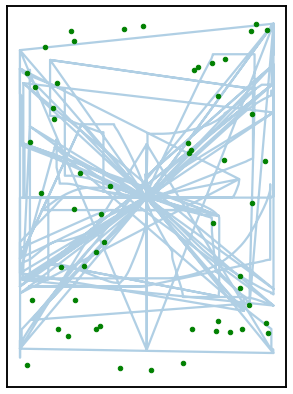

In [36]:
# Plot the positions of the recall selector, overlaid with chest positions
landmarks = {'positions' : chest_pos, 'color' : 'g'}
plot_positions(recall_pos, landmarks=landmarks, figsize=(5, 7))

## Trials

In [37]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x140283840677392
Fields:
  colnames: ['start_time' 'stop_time' 'chest_appear_time' 'chest_collision_time'
 'chest_disappear_time' 'chest_opening_time' 'chest_recall_start'
 'chest_recall_stop' 'chest_rotation_start' 'chest_rotation_stop'
 'chest_trials' 'confidence_prompt_time' 'confidence_response'
 'confidence_response_time' 'correct' 'distractor_correct'
 'distractor_start' 'distractor_stop' 'error' 'feedback_start'
 'feedback_stop' 'full_chest' 'homebase_transport_start'
 'homebase_transport_stop' 'n_chests' 'n_treasures' 'navigation_start'
 'navigation_stop' 'recall_start' 'recall_stop' 'recall_trials'
 'response_time' 'scorescreen_start' 'scorescreen_stop' 'stimulus'
 'tower_transport_start' 'tower_transport_stop']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    chest_appear_time_index <class 'hdmf.common.table.VectorIndex'>,
    chest_appear_time <class 'hdmf.common

In [38]:
# Check event names
event_names = nwbfile.trials.colnames
print(event_names)

('start_time', 'stop_time', 'chest_appear_time', 'chest_collision_time', 'chest_disappear_time', 'chest_opening_time', 'chest_recall_start', 'chest_recall_stop', 'chest_rotation_start', 'chest_rotation_stop', 'chest_trials', 'confidence_prompt_time', 'confidence_response', 'confidence_response_time', 'correct', 'distractor_correct', 'distractor_start', 'distractor_stop', 'error', 'feedback_start', 'feedback_stop', 'full_chest', 'homebase_transport_start', 'homebase_transport_stop', 'n_chests', 'n_treasures', 'navigation_start', 'navigation_stop', 'recall_start', 'recall_stop', 'recall_trials', 'response_time', 'scorescreen_start', 'scorescreen_stop', 'stimulus', 'tower_transport_start', 'tower_transport_stop')


In [39]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 14


In [40]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,chest_appear_time,chest_collision_time,chest_disappear_time,chest_opening_time,chest_recall_start,chest_recall_stop,chest_rotation_start,chest_rotation_stop,...,navigation_stop,recall_start,recall_stop,recall_trials,response_time,scorescreen_start,scorescreen_stop,stimulus,tower_transport_start,tower_transport_stop
id,,,,,,,,,,,,,,,,,,,,,
0,59.794607,187.457902,"[62.91563820838928, 83.24184441566467, 95.5039...","[81.65782833099365, 93.71695065498352, 102.083...","[83.24384450912476, 95.50496888160706, 104.467...","[81.73482918739319, 93.99495363235474, 102.959...","[144.67546772956848, 162.15564489364624]","[156.46358728408813, 164.30266690254211]","[81.65982842445374, 93.71695065498352, 102.083...","[81.7328290939331, 93.99495363235474, 102.9590...",...,109.249108,125.851277,164.399668,"[0, 0]","[156.2635850906372, 164.10166478157043]",175.036776,187.457902,"[Face_7, Face_24]",109.249108,111.117127
1,187.464902,271.094750,"[191.2289400100708, 198.17201042175293, 202.98...","[196.4829933643341, 201.39904308319092, 206.43...","[198.17201042175293, 202.98505926132202, 208.1...","[196.66299510002136, 201.4750440120697, 206.65...","[228.14531445503235, 246.64050221443176]","[232.0673542022705, 250.62554264068604]","[196.4829933643341, 201.39904308319092, 206.43...","[196.66299510002136, 201.4750440120697, 206.65...",...,212.473155,223.229265,250.640543,"[1, 1]","[231.86535215377808, 250.42454051971436]",259.055628,271.093750,"[Face_33, Face_12]",212.473155,215.250184
2,271.101750,335.680405,"[274.86678862571716, 285.3438947200775, 290.84...","[283.16187286376953, 288.9239311218262, 293.60...","[285.3438947200775, 290.8419506549835, 295.133...","[283.8358795642853, 289.3339352607727, 293.624...","[316.5872118473053, 321.62026286125183]","[320.0292468070984, 325.8623058795929]","[283.16187286376953, 288.9239311218262, 293.60...","[283.8348796367645, 289.3339352607727, 293.624...",...,300.539049,312.386169,325.966307,"[2, 2]","[319.8282446861267, 325.6613039970398]",334.395393,335.680405,"[Face_40, Face_37]",300.539049,303.686081
3,335.686405,394.288000,"[337.2024209499359, 346.262512922287, 352.8305...","[344.64249634742737, 350.8225591182709, 355.32...","[346.262512922287, 352.83057951927185, 356.928...","[344.7534976005554, 351.32356429100037, 355.41...","[374.46479892730713, 383.10788679122925]","[381.15786695480347, 386.58092188835144]","[344.6434962749481, 350.8225591182709, 355.321...","[344.7534976005554, 351.32256412506104, 355.41...",...,361.431667,370.054754,386.676923,"[3, 3]","[380.95586466789246, 386.37791991233826]",392.162978,394.287000,"[Face_8, Face_3]",361.431667,364.688700
4,394.294000,459.691664,"[398.05903840065, 406.6421253681183, 412.72218...","[404.9441080093384, 410.6441659927368, 418.143...","[406.6421253681183, 412.7221870422363, 419.776...","[405.13211011886597, 411.21317195892334, 418.2...","[440.20146584510803, 445.3325181007385, 448.97...","[443.74250173568726, 447.5755407810211, 450.94...","[404.9441080093384, 410.6441659927368, 418.143...","[405.13211011886597, 411.21317195892334, 418.2...",...,424.927311,435.959423,451.060576,"[4, 4, 4]","[443.5414996147156, 447.37453866004944, 450.74...",457.718643,459.691664,"[Face_16, Face_15, Face_5]",424.927311,427.982342


#### Confidence

In [41]:
# Count confidence answers
conf_counts = count_elements(nwbfile.trials.confidence_response.data[:],
                             labels=['yes', 'maybe', 'no'])

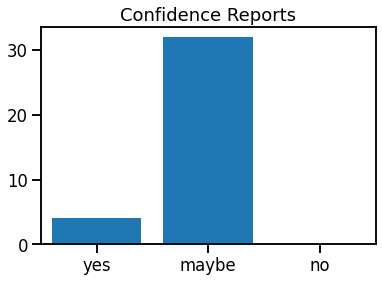

In [42]:
# Plot confidence answers
plot_bar(conf_counts.values(), labels=conf_counts.keys(), title='Confidence Reports')

#### Response Error

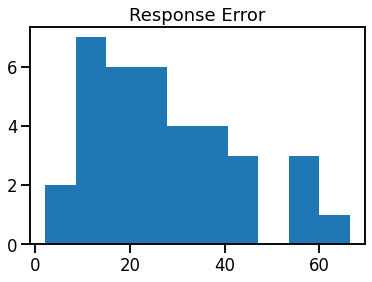

In [43]:
# Plot response error
plot_hist(nwbfile.trials.error.data[:], title='Response Error')

## Check Unit Data

Note that we only look at units that are marked to keep.

In [44]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x140283840679648
Fields:
  colnames: ['channel' 'cluster' 'keep' 'location' 'wvID' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    cluster <class 'hdmf.common.table.VectorData'>,
    keep <class 'hdmf.common.table.VectorData'>,
    location <class 'hdmf.common.table.VectorData'>,
    wvID <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with oSort by Runnan Cao.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [45]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 100


In [46]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 124800


In [47]:
# Count the number of units per wire
channel_counts = count_elements(nwbfile.units.channel[:])
counts_per_wire = count_elements(channel_counts.values(), labels='count', sort=True)

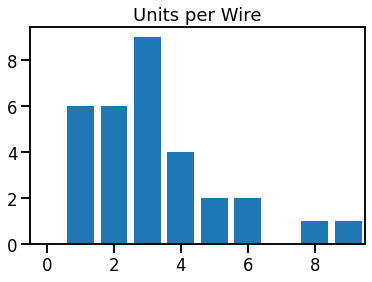

In [48]:
# Plot the distribution of units per wire
plot_bar(counts_per_wire.values(), labels=counts_per_wire.keys(), title='Units per Wire')

#### Check Keep & Reject Neurons

In [49]:
# Check how many units are marked to keep
n_keep = sum(nwbfile.units.keep[:])
print('Number of keep neurons: {}'.format(n_keep))

Number of keep neurons: 74


In [50]:
# Get the indices of the neurons to keep
keep_inds = np.where(nwbfile.units.keep[:])[0]
assert len(keep_inds) == n_keep

In [51]:
# Get the indices of the neurons that are rejected
reject_inds = np.where((nwbfile.units.keep[:] - 1) * -1)[0]
assert len(reject_inds) + n_keep == n_units

In [52]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(nwbfile.units.get_unit_spike_times(s_ind)) \
         for s_ind in keep_inds]

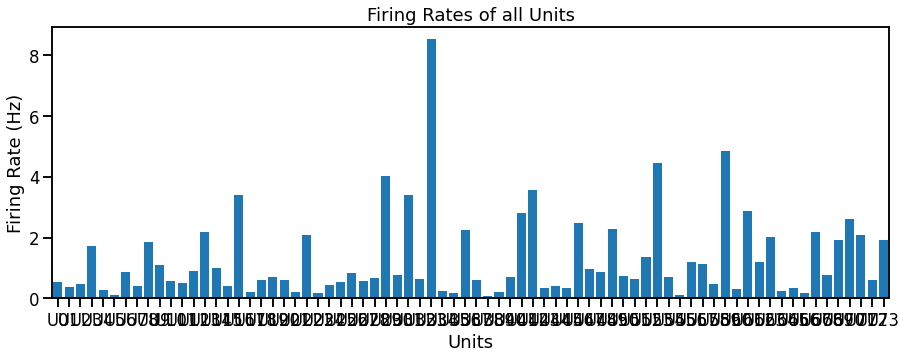

In [53]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

In [54]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in keep_inds]

In [55]:
# Set start and stop time of the task (note that 0 is task start time)
st = 0
en = nwbfile.trials.stop_time[-1]

In [56]:
# Compute the task length, in minutes
task_len = convert_sec_to_min(en)

In [57]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 20.68 minutes


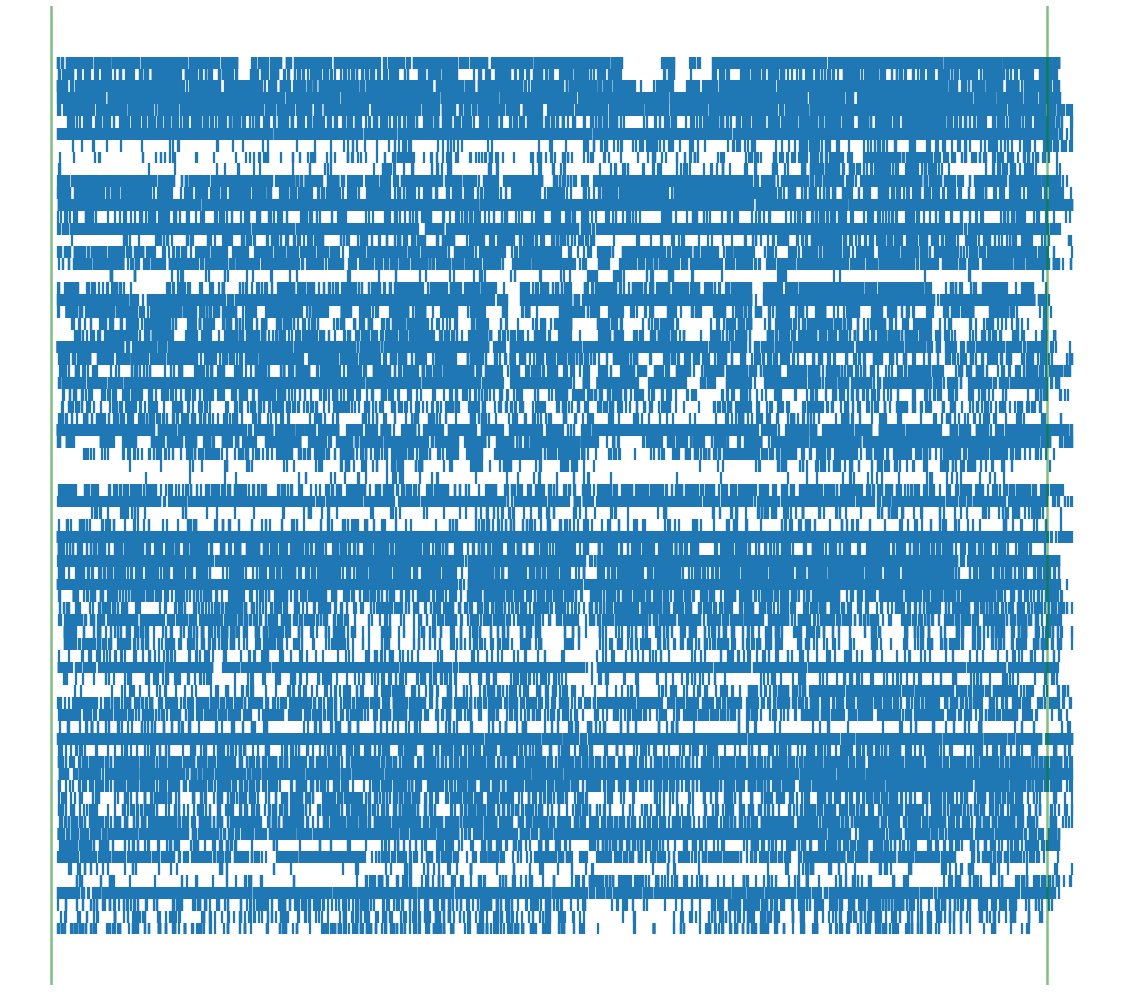

In [58]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

In [59]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in keep_inds:
#     spikes = nwbfile.units.get_unit_spike_times(uind)
#     plot_rasters(spikes, show_axis=True, figsize=(16, 2))